In [1]:
# Set this
CBL_DIR = "/home/alfonso/CosmoBolognaLib/"

In [2]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import cividis, gist_gray, rainbow

import healpy as hp

from astropy.io import fits

import CosmoBolognaLib as cbl
from CosmoBolognaLib import DoubleVector as dv
cbl.SetDirs(CBL_DIR, cbl.fullpath("./"))
import os

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=16)

import matplotlib.pyplot as plt

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

eb_default_kwargs = {"ls" : "",
                     "barsabove" : False,
                     "ecolor" : "k",
                     "mec" : "k",
                     "elinewidth" : 1.2,
                     "mew" : 1.2,
                     "capsize" : 3}

from scipy.interpolate import interp1d
from scipy.integrate import quad

import multiprocessing

import emcee
import chainconsumer

from tqdm.notebook import tqdm

# Clustering ok PSZ sample

This notebook serves as a primer to compute clustering of SZ selected galaxy clusters from Planck data.

To complete the task we must take a couple of mandatory steps:

1. Download the files.
2. Select the sample.
3. Create the random.
    * Generate random longitude and latitude, with a mask.
    * Generate random redshifts (from dn/dz or by shuffling).
4. Generate the regions.
5. Compute the two-point correlation function monopole and its covariance matrix.


# Step 1 - Download the files

In order to begin, please download the following files from here https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/HFI_Products.html and put the in the input directory.

* The cluster sample: HFI_PCCS_SZ-union_R2.08.fits.gz
* The selection function: HFI_PCCS_SZ-selfunc-union-survey_R2.08.fits
* The SZ mask: COM_Mask_Compton-SZMap_2048_R2.00.fits

The total size is approximatively 1.4 Gb.

Further information can be found here: https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Catalogues#S.2FN_threshold_map



In [3]:
# Set and create the input directory
input_dir = "../input/"
os.makedirs(input_dir, exist_ok=True)

# root link
paths = ["https://irsa.ipac.caltech.edu/data/Planck/release_2/catalogs/",
        "https://irsa.ipac.caltech.edu/data/Planck/release_2/catalogs/",
        "https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/masks/"]

# File names
file_names = ["HFI_PCCS_SZ-union_R2.08.fits.gz", #The cluster sample
              "HFI_PCCS_SZ-selfunc-union-survey_R2.08.fits", #The selection function
              "COM_Mask_Compton-SZMap_2048_R2.00.fits"] # The SZ map mask 

# Download the cluster sample
for pp, fn in zip(paths, file_names):
    if not os.path.exists(input_dir+fn):
        os.system("cd {0} && wget {1}{2}".format(input_dir, pp, fn))

# Step 2 - Look at the data and first selection

## 2.1 - Mask

We'll first look at the mask. This is composed by two elements:

1. Galaxy mask; this is a binary mask (0, 1) that exclude the galaxy contribution (notice that coordinates are l, b)
2. Holes mask; hole mask, exclude contaminated regions (star, large galaxies etc...)

Our final mask will be a combination of these two.

**Attention** the cluster sample is already masked

In [4]:
# Read map
survey_map_intersec = hp.read_map("../input/HFI_PCCS_SZ-selfunc-union-survey_R2.08.fits") # Mask the galaxy
holes = hp.read_map("../input/COM_Mask_Compton-SZMap_2048_R2.00.fits", field=4) # Field4 is the holes mask
visibility = hp.ud_grade(hp.read_map("HFI_ysz_visibility_zmean_mass_mean.fits"), 2048)

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


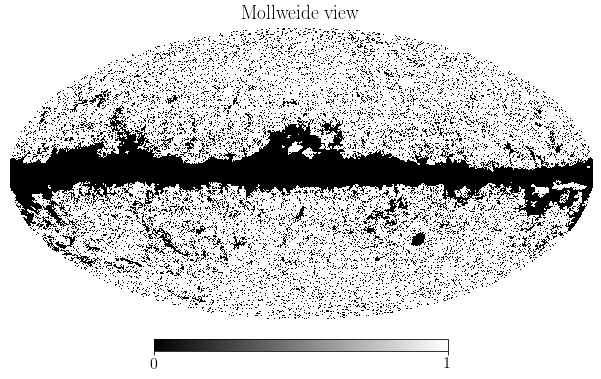

In [5]:
hp.mollview(holes*survey_map_intersec, cmap=gist_gray)

/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


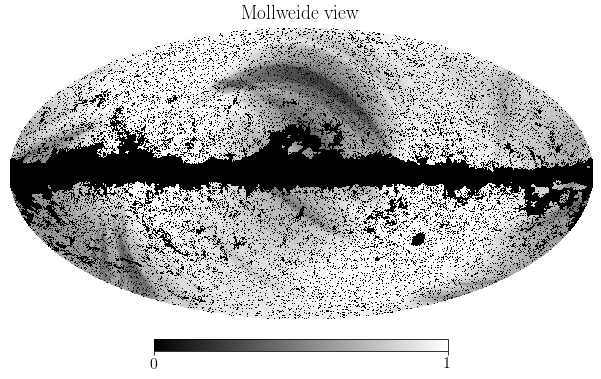

In [6]:
hp.mollview(holes*survey_map_intersec*visibility, cmap=gist_gray)

## Step 2.2 Galaxy cluster sample - first look

In [7]:
# Read the data
union_table = Table().read("../input/HFI_PCCS_SZ-union_R2.08.fits.gz").to_pandas()
union_table["REDSHIFT_ID"] = union_table["REDSHIFT_ID"].str.decode("utf-8")

In [11]:
union_table.columns

Index(['INDEX', 'NAME', 'GLON', 'GLAT', 'RA', 'DEC', 'POS_ERR', 'SNR',
       'PIPELINE', 'PIPE_DET', 'PCCS2', 'PSZ', 'IR_FLAG', 'Q_NEURAL', 'Y5R500',
       'Y5R500_ERR', 'VALIDATION', 'REDSHIFT_ID', 'REDSHIFT', 'MSZ',
       'MSZ_ERR_UP', 'MSZ_ERR_LOW', 'MCXC', 'REDMAPPER', 'ACT', 'SPT',
       'WISE_FLAG', 'AMI_EVIDENCE', 'COSMO', 'COMMENT'],
      dtype='object')

In [12]:
# Dataset appearence (pandas)
union_table["isMCXC"] = union_table["MCXC"] != b""
union_table["isREDMAPPER"] = union_table["REDMAPPER"] != b""
union_table["isACT"] = union_table["ACT"] != b""
union_table["isSPT"] = union_table["SPT"] != b""

In [9]:
# Dataset columns
union_table.columns

Index(['INDEX', 'NAME', 'GLON', 'GLAT', 'RA', 'DEC', 'POS_ERR', 'SNR',
       'PIPELINE', 'PIPE_DET', 'PCCS2', 'PSZ', 'IR_FLAG', 'Q_NEURAL', 'Y5R500',
       'Y5R500_ERR', 'VALIDATION', 'REDSHIFT_ID', 'REDSHIFT', 'MSZ',
       'MSZ_ERR_UP', 'MSZ_ERR_LOW', 'MCXC', 'REDMAPPER', 'ACT', 'SPT',
       'WISE_FLAG', 'AMI_EVIDENCE', 'COSMO', 'COMMENT', 'isMCXC',
       'isREDMAPPER', 'isACT', 'isSPT'],
      dtype='object')

In [10]:
OmegaM = 0.3;
Omega_b = 0.045;
Omega_nu = 0.;
massless_neutrinos = 3.04;
massive_neutrinos = 0; 
OmegaL = 1.-OmegaM;
Omega_radiation = 0.;
hh = 0.7;
scalar_amp = 2.742e-9;
scalar_pivot = 0.05;
n_s = 1;
wa = 0.;
w0 = -1.;   

sr_to_arcmin_sq = 11818102.860

cosmology = cbl.Cosmology (OmegaM, Omega_b, Omega_nu, massless_neutrinos, massive_neutrinos, OmegaL, Omega_radiation, hh, scalar_amp, scalar_pivot, n_s, w0, wa, 0, 1, 0.09, "LCDM", False)
def Y500_mean(z, cosmology, M500, beta=0.66, Ystar = 10**-0.19, alpha=1.79, b=0):
    return Ystar * (cosmology.hh()/0.7) ** (-2 + alpha) * (( 1- b ) * M500/6.e14)**alpha * \
           (cosmology.EE(z)**-beta * cosmology.D_A(z)**2/1.e-4)**-1

<Figure size 600x400 with 0 Axes>

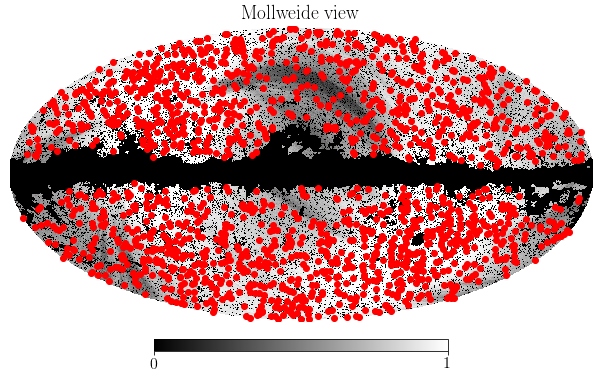

In [49]:
plt.figure(1, dpi=100)
hp.mollview(holes*survey_map_intersec*visibility, cmap=gist_gray)


hp.projscatter(theta = union_table["GLON"],
               phi = union_table["GLAT"], 
               lonlat = True,
               coord = "G",
               color="r")

## Step 2.3 - Selection

This is where we should experiment. There are different selection we can do (one by one or simultaneously)
For now, we only select those objects that have a redshift measure

Some examples are:

- intersec sample: subselection of objects that have been found by all the three SZ cluster finder algorithms
  The flag is `PIPE_DET`. It can take different values the format is: 
  * algoritmh 1 has weight 1
  * algorithm 2 has weight 10
  * algorithm 3 has weight 100
  
  The sum of the weights corresponding to the algorithms that detected the object is the final value for `PIPE_DET`
  
  E.g. we want to select only the objects that have been selected by all the algorithms; we must then look for 
  `PIPE_DET = 111`.
- COSMO: Whatever an object has been used for cosmological analyses or not. The flag is `COSMO` and can be `True` or   `False`

  **Attention** To use this selection yoou must use a different mask file (HFI_PCCS_SZ-selfunc-union-cosmolog_R2.08.fits)

In [55]:
# You can play here to perform different selections
final_sample = union_table[(union_table["REDSHIFT"] > 0) &\
                           (union_table["REDSHIFT"] <0.8)]# &\
                           #(union_table["REDSHIFT_ID"].str.contains("RXC"))]

In [56]:
final_sample.columns

Index(['INDEX', 'NAME', 'GLON', 'GLAT', 'RA', 'DEC', 'POS_ERR', 'SNR',
       'PIPELINE', 'PIPE_DET', 'PCCS2', 'PSZ', 'IR_FLAG', 'Q_NEURAL', 'Y5R500',
       'Y5R500_ERR', 'VALIDATION', 'REDSHIFT_ID', 'REDSHIFT', 'MSZ',
       'MSZ_ERR_UP', 'MSZ_ERR_LOW', 'MCXC', 'REDMAPPER', 'ACT', 'SPT',
       'WISE_FLAG', 'AMI_EVIDENCE', 'COSMO', 'COMMENT', 'isMCXC',
       'isREDMAPPER', 'isACT', 'isSPT'],
      dtype='object')

/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


<Figure size 600x400 with 0 Axes>

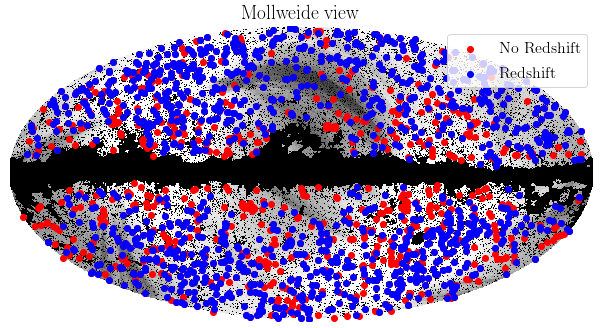

In [57]:
plt.figure(1, dpi=100)
hp.mollview(holes*survey_map_intersec*visibility, cmap=gist_gray, cbar=False)

hp.projscatter(theta = union_table["GLON"],
               phi = union_table["GLAT"], 
               lonlat = True,
               coord = "G",
               color="r",
               label='No Redshift')

hp.projscatter(theta = final_sample["GLON"],
               phi = final_sample["GLAT"], 
               lonlat = True,
               coord = "G",
               color="b",
               label='Redshift')

plt.legend(loc="upper right")

<Figure size 600x400 with 0 Axes>

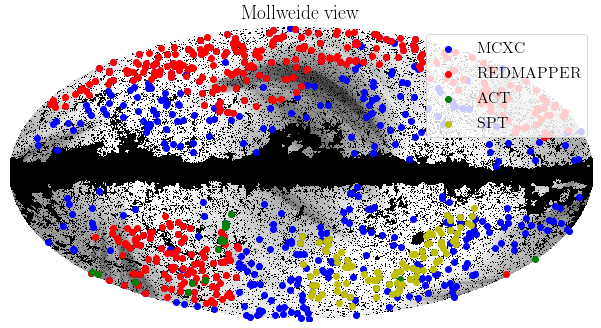

In [58]:
plt.figure(1, dpi=100)
hp.mollview(holes*survey_map_intersec*visibility, cmap=gist_gray, cbar=False)

hp.projscatter(theta = final_sample[final_sample["MCXC"]!=b""]["GLON"],
               phi = final_sample[final_sample["MCXC"]!=b""]["GLAT"], 
               lonlat = True,
               coord = "G",
               color="b",
               label='MCXC')

hp.projscatter(theta = final_sample[final_sample["REDMAPPER"]!=b""]["GLON"],
               phi = final_sample[final_sample["REDMAPPER"]!=b""]["GLAT"], 
               lonlat = True,
               coord = "G",
               color="r",
               label='REDMAPPER')

hp.projscatter(theta = final_sample[final_sample["ACT"]!=b""]["GLON"],
               phi = final_sample[final_sample["ACT"]!=b""]["GLAT"], 
               lonlat = True,
               coord = "G",
               color="g",
               label='ACT')

hp.projscatter(theta = final_sample[final_sample["SPT"]!=b""]["GLON"],
               phi = final_sample[final_sample["SPT"]!=b""]["GLAT"], 
               lonlat = True,
               coord = "G",
               color="y",
               label='SPT')

plt.legend(loc="upper right")

In [16]:
# Compute redshift distribution function
z_bins, n_z, err_n_z = cbl.DoubleVector(), cbl.DoubleVector(),  cbl.DoubleVector()

nbins = 100
sigmaz = 0.02

cbl.distribution (z_bins,
                  n_z,
                  err_n_z,
                  dv(final_sample["REDSHIFT"].tolist()),
                  dv(np.ones(len(final_sample))),
                  nbins,
                  True,
                  "test.dat",
                  1.,
                  final_sample["REDSHIFT"].min().astype(np.float64),
                  final_sample["REDSHIFT"].max().astype(np.float64),
                  "Linear",
                  True ,
                  sigmaz)

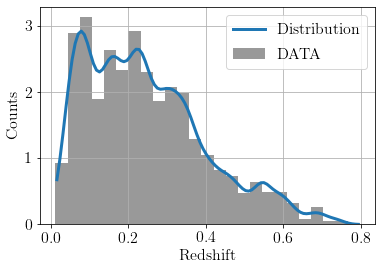

In [17]:
# Plot!
integral = np.sum(n_z)
plt.hist(final_sample["REDSHIFT"], bins=25, density=True, label="DATA", color="0.6")
plt.plot(z_bins, n_z/(integral*(z_bins[1]-z_bins[0])), label="Distribution", lw=3)
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Counts")
plt.grid(True)

# Step 3 - Galaxy cluster masses

The cluster catalogues comes with an estimate of the cluster mass (flag `MSZ`). 

From https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Catalogues#S.2FN_threshold_map:
> MSZ is the hydrostatic mass assuming the best-fit Y-M scaling relation of Arnaud (2010) as a prior. The uncertainties are statistical and based on the Planck measurement uncertainties only. Not included in the uncertainties are the statistical errors on the scaling relation, the intrinsic scatter in the relation, or systematic errors in data selection for the scaling relation fit. 



In [18]:
# Create cosmology

planck_cosmology = cbl.Cosmology(cbl.CosmologicalModel__Planck18_)

mass, redshift = 1.e14*final_sample["MSZ"]*planck_cosmology.hh(), final_sample["REDSHIFT"]

Delta_crit = 500


In [19]:
hydro_bias = np.linspace(0, 0.99, 20)

def func(i):
    new_mass = (1-hydro_bias[i])*mass
    results = planck_cosmology.bias_eff_mass_grid (dv(new_mass.to_list()),
                                                   dv(redshift.to_list()),
                                                   "Tinker",
                                                   "CAMB",
                                                   "mean_bias", 
                                                   True,
                                                   "test",
                                                   Delta_crit)
    cluster_bias[i] = np.array(results)

manager = multiprocessing.Manager()

cluster_bias = manager.dict()

jobs = []
for i in range(len(hydro_bias)):
    p = multiprocessing.Process(target = func, args=(i,))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()

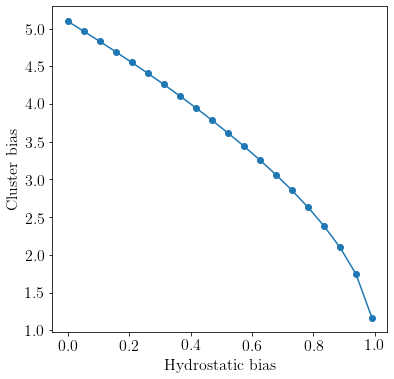

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlabel("Hydrostatic bias")
ax.set_ylabel("Cluster bias")

cl_bias = []
for i in range(len(hydro_bias)):
    cl_bias.append(cluster_bias[i][0])

ax.plot(hydro_bias, cl_bias, 'o-')

# Step 4 - Generate random sample

In [21]:
# Set some variables

N_R = 100
SEED = 666

# Modify this if you want to hardcode the size of the random
nrandom = N_R * len(final_sample)

np.random.seed(SEED)

In [22]:
# This is a non-pythonic way to perform the selection with a mask
# It is fast, as we have to extract few thousands of objects.

ran_lon, ran_lat = [], []
n=0

nside = hp.npix2nside(len(survey_map_intersec))

print(nside)

while (n<nrandom):
    colat, lon = np.arccos(np.random.random(1)*2-1), np.random.random(1)*2*np.pi
    pix = hp.ang2pix(nside, colat[0], lon[0],)
    
    if (np.random.random() < survey_map_intersec[pix]*holes[pix]*visibility[pix]):
        ran_lat.append(np.pi/2-colat[0])
        ran_lon.append(lon[0])
        n+=1
    
    #if (survey_map_intersec[pix]*holes[pix]*visibility[pix]>0):
    #    ran_lat.append(np.pi/2-colat[0])
    #    ran_lon.append(lon[0])
    #    n+=1

2048


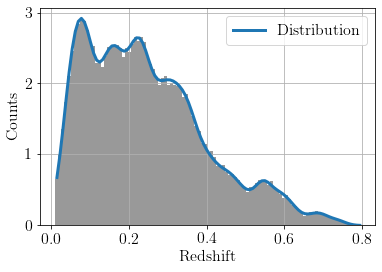

In [23]:
# Generate a random redshift vector from galaxy clusters observed dn/dz
ran_z = cbl.vector_from_distribution (nrandom,
                                      z_bins,
                                      n_z,
                                      final_sample["REDSHIFT"].min().astype(np.float64),
                                      final_sample["REDSHIFT"].max().astype(np.float64),
                                      SEED)

# Generate a random redshift vector shuffling observed galaxy clusters redshifts
#ran_z = np.random.choice(final_sample["REDSHIFT"].tolist(), nrandom)

plt.plot(z_bins, n_z/(integral*(z_bins[1]-z_bins[0])), label="Distribution", lw=3)
_ = plt.hist(ran_z, density=True, bins=100, color="0.6")
plt.legend()
plt.xlabel("Redshift")
plt.ylabel("Counts")
plt.grid(True)

## Step 5 - Measure 2PCF

Now that data and random samples are set, we can measure clustering.

We take advantage of CosmoBolognaLib methods and classes:

We must
1. Define a fiducial cosmology. We use the Planck et collaborators 2018 cosmology.
2. Create the Data and Random Catalogue.
3. Assign Regions for Jackknife resampling.
4. Compute the two-point correlation function and its covariance matrix.

## Step 5.1 - Define the fiducial cosmology

In [24]:
# Create cosmology

cosmology = cbl.Cosmology(cbl.CosmologicalModel__Planck18_)

## Step 5.2 - Define the data and random samples

In [25]:
# Create Data catalogue
dataCat = cbl.Catalogue(cbl.ObjectType__Cluster_,
                     cbl.CoordinateType__observed_,
                     (final_sample["GLON"]*np.pi/180).tolist(),
                     (final_sample["GLAT"]*np.pi/180).tolist(),
                     (final_sample["REDSHIFT"]).tolist(),
                     cosmology)

In [26]:
# Create random catalogue
randCat = cbl.Catalogue(cbl.ObjectType__Random_,
                     cbl.CoordinateType__observed_,
                     dv(ran_lon),
                     dv(ran_lat),
                     dv(ran_z),
                     cosmology)

## Step 5.3 - Assign regions

Regions are needed for the computation of the covariance matrix

We exploit `healpy` functionalities to split the sky in regions of equale area. 

Steps are:

1. Set the number of pixel with the parameter `n_side` parameter. The number of pixels is: $N_{pix} = 12 \times N_{side}^2$ (https://healpix.jpl.nasa.gov/pdf/intro.pdf).
2. Assign the region as the pixel numebr a data particle belongs.
3. Repeat step 2. for random points.
4. Check that everything is fine with `cbl.check_regions`.

In [27]:
# We use healpy to create regions

nside_jk = 4
npix_jk = hp.nside2npix(nside_jk)
regions_random = hp.ang2pix(nside_jk, np.pi/2-np.array(ran_lat), ran_lon).tolist()
regions_data = hp.ang2pix(nside_jk, np.pi/2-final_sample["GLAT"]*np.pi/180, final_sample["GLON"]*np.pi/180).tolist()

/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


Text(0.5, 0, 'Region number')

<Figure size 600x400 with 0 Axes>

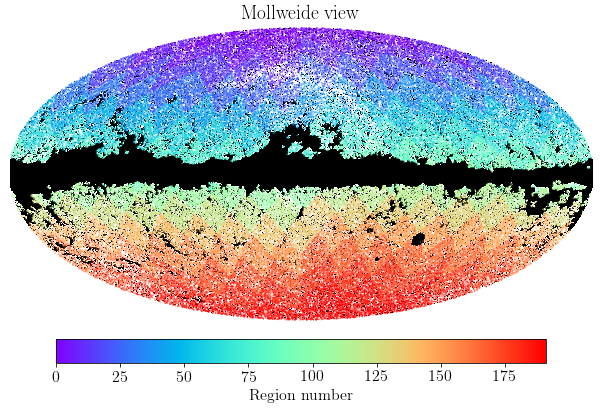

In [28]:
plt.figure(1, dpi=100)
hp.mollview(holes*survey_map_intersec, cmap=gist_gray, cbar=False)

cbar = hp.projscatter(theta = np.array(ran_lon)*180/np.pi,
                      phi = np.array(ran_lat)*180/np.pi,
                      c = regions_random,
                      lonlat = True,
                      coord = "G",
                      cmap=rainbow, s = 0.1)

cbar = plt.colorbar(cbar, orientation="horizontal", pad = 0.05, fraction=0.07)
cbar.ax.set_xlabel("Region number")

In [29]:
# Assign regions
dataCat.set_var(cbl.Var__Region_, dv(regions_data))
randCat.set_var(cbl.Var__Region_, dv(regions_random))

cbl.check_regions(dataCat, randCat)

## Step 5.4 - Measure clustering 

In [30]:
## Clustering!

# binnig parameters #
rMin = 10.   # minimum separation 
rMax = 200.  # maximum separation 
nbins = 15  # number of bins
shift = 0.5 # spatial shift used to set the bin centre 

# create the object used to measure the two-point correlation function
TwoP = cbl.TwoPointCorrelation1D_monopole(dataCat,
                                          randCat,
                                          cbl.BinType__logarithmic_,
                                          rMin,
                                          rMax,
                                          nbins,
                                          shift)

# Input/Output files and directories 
file_catalogue = ("../input/cat.dat",)
dir_output = "../output/"
dir_pairs = dir_output+"pairs/"

# measure the two-point correlation function
TwoP.measure(cbl.ErrorType__Jackknife_, dir_pairs)

# store the output data
file_xi = "xi_JK.dat"
TwoP.write(dir_output, file_xi)

file_cov = "cov_JK.dat"
TwoP.write_covariance(dir_output, file_cov)


In [31]:
dataset = TwoP.dataset()

rad = np.array(dataset.xx())
xi = np.array(dataset.data())

covariance = np.array(dataset.covariance())
std = np.sqrt(np.diagonal(covariance))
correlation = covariance/np.outer(std, std)
inverse = np.linalg.inv(covariance)

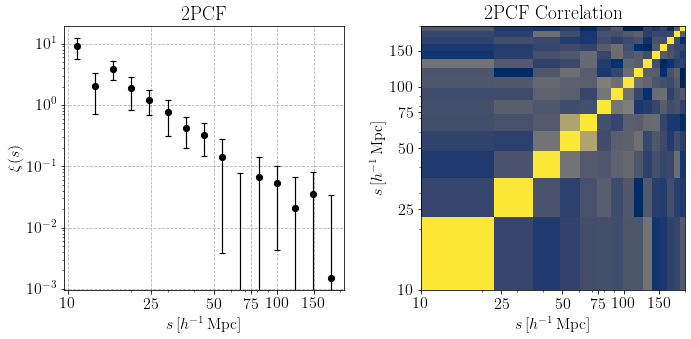

In [32]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First axis

ax1.set_title("2PCF")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.errorbar(rad, xi, yerr=std, fmt="o", color="k", **eb_default_kwargs)

ax1.xaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax1.xaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

ax1.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax1.set_ylabel(r"$ \xi(s) $")
ax1.grid(True, ls="--")

# Second axis
ax2.set_title("2PCF Correlation")
ax2.imshow(correlation, cmap=cividis, extent = [rMin, rMax, rMin, rMax], origin="lower")
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax2.set_ylabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")

ax2.xaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax2.xaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

ax2.yaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax2.yaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

figure.tight_layout()

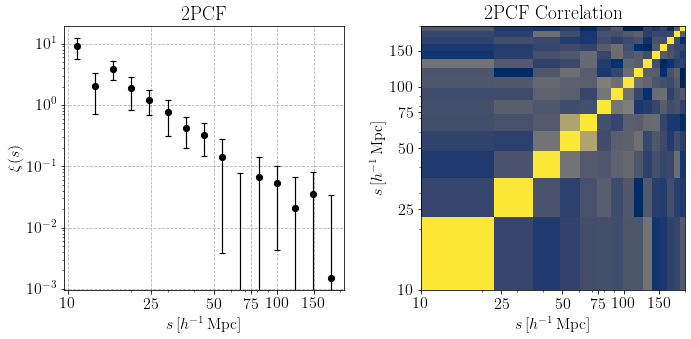

In [33]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First axis

ax1.set_title("2PCF")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.errorbar(rad, xi, yerr=std, fmt="o", color="k", **eb_default_kwargs)

ax1.xaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax1.xaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

ax1.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax1.set_ylabel(r"$ \xi(s) $")
ax1.grid(True, ls="--")

# Second axis
ax2.set_title("2PCF Correlation")
ax2.imshow(correlation, cmap=cividis, extent = [rMin, rMax, rMin, rMax], origin="lower")
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax2.set_ylabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")

ax2.xaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax2.xaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

ax2.yaxis.set_ticks([10, 25, 50, 75, 100, 150])
ax2.yaxis.set_ticklabels([10, 25, 50, 75, 100, 150])

figure.tight_layout()

# Step 6 - Model 2PCF 

In [34]:
cosmology = cbl.Cosmology(cbl.CosmologicalModel__Planck15_)

redshift = final_sample["REDSHIFT"].median().astype(np.float64)

linear_growth_rate = cosmology.linear_growth_rate(redshift)

kk = np.logspace(-4, 2, 512)
pk = cosmology.Pk_matter(kk, "CAMB", False, redshift)

rad_model = np.linspace(1, 250, 200)
xi_model = np.array(cbl.transform_FFTlog(rad_model, 1, kk, pk*np.exp(-kk**2), 0))

interp_xi = interp1d(rad_model, xi_model, kind="cubic")

log_bins = np.log10(rad)
log_bin_size = log_bins[1]-log_bins[0]
log_edges = np.array([[lb-0.5*log_bin_size, lb+0.5*log_bin_size] for lb in log_bins])
edges = 10**log_edges

xi_fix = np.array([quad( lambda rr : rr**2*interp_xi(rr), a=ee[0], b=ee[1])[0] for ee in edges])
norm = np.array([quad( lambda rr : rr**2, a=ee[0], b=ee[1])[0] for ee in edges])

xi_fix = interp_xi(rad) #xi_fix/norm

In [35]:
#Vanilla model

parameters = [r"$b_1$"]

def normalization(b1):
    beta = linear_growth_rate/b1
    return b1**2 * (1 + 2./3 * beta + 1./5 * beta**2)

def model(b1, rad=rad):
    return normalization(b1) * xi_fix

def lnlik (theta):
    diff = xi - model(theta)
    chi2 = np.dot(diff, np.dot(inverse, diff))
    return -0.5 * chi2

def lnprior(b1):
    if (b1>0.5) & (b1<10):
        return 0
    return -np.inf

def lnprob(b1):
    lnpr = lnprior(b1)
    if not np.isfinite(lnpr):
        return -np.inf
    return lnlik(b1) + lnpr

In [36]:
from scipy.optimize import minimize

result = minimize(lambda theta : -2 * lnprob(theta),
                  x0 = 2,
                  method="Powell")

print(result.x)

[4.61513665]


In [37]:
nwalkers = 100
chain_size = 10000
ndim = 1

pos = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, chain_size, progress=True);

100%|██████████| 10000/10000 [00:17<00:00, 559.90it/s]


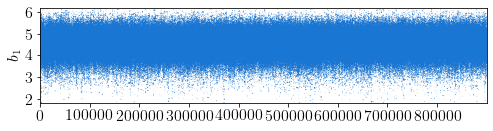

In [38]:
chain = sampler.get_chain(flat=True)

burnin = 100000
thin = 1

cc = chainconsumer.ChainConsumer()
cc.add_chain(chain[burnin:-1:thin], parameters=parameters)
cc.plotter.plot_walks();

low_1s_b, median_b, up_1s_b = np.percentile(chain, [16, 50, 86])
err_low = median_b-low_1s_b
err_up = up_1s_b-median_b

In [39]:
rad_model = np.linspace(rMin, rMax, 100)
new_xi_DM = interp_xi(rad_model)
models = [normalization(b1) * new_xi_DM  for b1 in chain]

In [40]:
low_1s_model, median_model, up_1s_model = np.percentile(models, [16, 50, 84], axis=0)

5.097682120428135


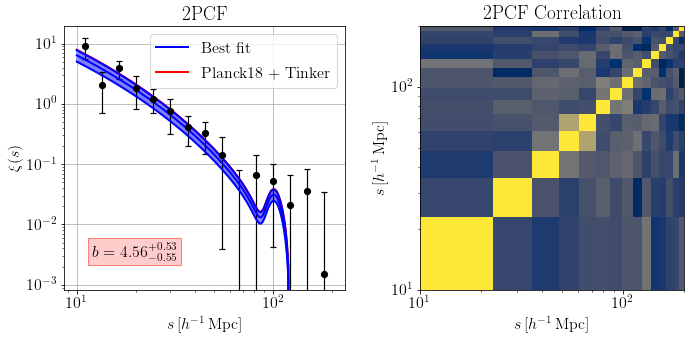

In [41]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# First axis

ax1.set_title("2PCF")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.errorbar(rad, xi, yerr=std, fmt="o", color="k", **eb_default_kwargs)
ax1.plot(rad_model, median_model, lw=2, color="b", label="Best fit")
ax1.plot(rad_model, normalization(cl_bias[0])*interp_xi(rad_model), lw=2, color="r", label="Planck18 + Tinker")
print(cl_bias[0])
ax1.plot(rad_model, low_1s_model, lw=2, color="b")
ax1.plot(rad_model, up_1s_model, lw=2, color="b")
ax1.fill_between(rad_model, low_1s_model, up_1s_model, color="b", alpha=0.5)
ax1.legend(loc="upper right")
ax1.text(12, 3.e-3, r"$b = %2.2f^{+%2.2f}_{-%2.2f}$"%(median_b, err_up, err_low),
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)))

ax1.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax1.set_ylabel(r"$ \xi(s) $")
ax1.grid(True)

# Second axis
ax2.set_title("2PCF Correlation")
ax2.imshow(correlation, cmap=cividis, extent = [rMin, rMax, rMin, rMax], origin="lower")
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")
ax2.set_ylabel(r"$ s \, [h^{-1} \, \mathrm{Mpc}]$")

figure.tight_layout()

In [42]:
interp_cluster_bias = interp1d(hydro_bias, cl_bias, kind="cubic", fill_value="extrapolate")
def func(x, value):
    return np.abs(interp_cluster_bias(1-x)-value)

hydro_bias_bestfit = minimize(func, x0=0, args=median_b).x
hydro_bias_low_1s = minimize(func, x0=0, args=low_1s_b)
hydro_bias_up_1s = minimize(func, x0=0, args=up_1s_b)

hydro_bias_low_1s, hydro_bias_up_1s = np.sort([hydro_bias_low_1s.x, hydro_bias_up_1s.x])#[-1::-1]
print(hydro_bias_low_1s, hydro_bias_up_1s)

[0.60397159] [0.99822683]


/home/alfonso/miniconda3/envs/cbl/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


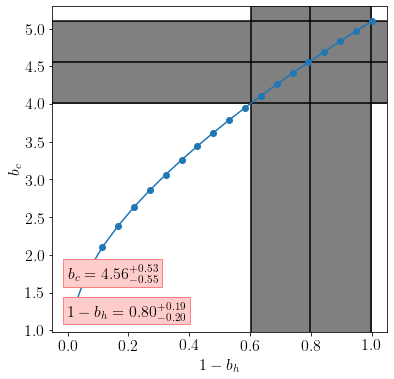

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_ylabel(r"$b_c$")
ax.set_xlabel(r"$1-b_h$")


    
low_1s_b, median_b, up_1s_b
ax.axhline(low_1s_b, color="k")
ax.axhline(median_b, color="k")
ax.axhline(up_1s_b, color="k")

ax.axvline(hydro_bias_up_1s, color="k")
ax.axvline(hydro_bias_bestfit, color="k")
ax.axvline(hydro_bias_low_1s, color="k")

ax.axhspan(low_1s_b, up_1s_b, color="0.5" )
ax.axvspan(hydro_bias_low_1s, hydro_bias_up_1s, color="0.5" )

ax.set_xlim(-0.05, 1.05)
ax.plot(1-hydro_bias, cl_bias, 'o-')

ax.text(0., 1.7, r"$b_c = %2.2f^{+%2.2f}_{-%2.2f}$"%(median_b, err_up, err_low),
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)))

ax.text(0., 1.2, r"$1-b_h = %2.2f^{+%2.2f}_{-%2.2f}$"%(hydro_bias_bestfit,
                                                     hydro_bias_bestfit-hydro_bias_low_1s,
                                                     hydro_bias_up_1s-hydro_bias_bestfit),
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)));